In [1]:
"""Load the dataset and dataset config"""
from karanir.datasets.playroom_dataset import PlayroomDataset
from torch.utils.data import DataLoader
dataset_dir = "/Users/melkor/Documents/datasets/Playroom"

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 01/10/24 07:29:53.148 1981394] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
"""Arguments or the dataset config"""
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--compute_flow",           default = False)
parser.add_argument("--precompute_flow",        default = False)
args = parser.parse_args(args = [])

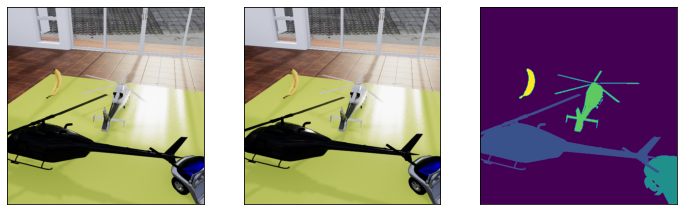

In [3]:
import matplotlib.pyplot as plt
dataset = PlayroomDataset(True, args, dataset_dir = dataset_dir, flow = False)
loader = DataLoader(dataset, batch_size = 1, shuffle = True)

for sample in loader:break;

def visualize_sample(sample, fig_name = "visualize sample", n = 12):
    fig = plt.figure(fig_name, frameon = False, figsize = (n,n * 3))
    for i,k in enumerate(sample):
        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(sample[k][0])
        plt.xticks([]);plt.yticks([]) # ignore all the label tick and just show the pics
    plt.show()

visualize_sample(sample)

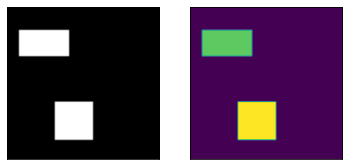

In [4]:
"""Build the SceneNet that performs visual grouping with conditions"""
from karanir.thanagor.perception import SceneNet
from karanir.thanagor.model import config
import torchvision
import torch

resolution = (128,128)
img = sample["img1"] / 255.
img = torchvision.transforms.Resize(resolution)(img.permute(0,3,1,2))

gt_seg = sample["gt_segment"]
gt_seg = torchvision.transforms.Resize(resolution)(gt_seg)

"""Build a test case to segment simple data like squares and other geometrics"""

if 1:
    B = 1
    H , W = (64,64)
    img = torch.zeros([B, 3, H, W])
    img[:,:,40:56,20:36] = 1.0
    img[:,:,10:21,5:26] = 1.0

    gt_seg = torch.zeros([B, H, W])
    gt_seg[:,40:56,20:36] = 4.0
    gt_seg[:,10:21,5:26] = 3.0
    gt_seg = gt_seg.long()
    resolution = (64,64)

""" Down Cast the images into the resolution of (128,128)"""
fig = plt.figure("down sample images")
ax1 = fig.add_subplot(121)
ax1.imshow(img[0].permute(1,2,0)); plt.xticks([]); plt.yticks([])
ax2 = fig.add_subplot(122)
ax2.imshow(gt_seg[0]); plt.xticks([]); plt.yticks([])
plt.show()

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


shape:[1, 64, 64, 10] max:1.0 min:2.061161463728922e-09


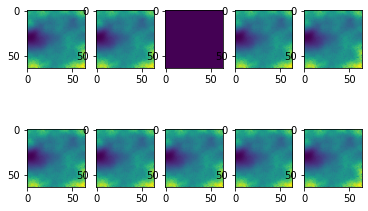

In [5]:
import torch
from karanir.thanagor.perception import SceneNet, generate_local_indices
from karanir.thanagor.model import config
from karanir.utils.tensor import stats_summary

config.resolution = resolution
percept_model = SceneNet(config)


outputs = percept_model(img, gt_seg.unsqueeze(1))
stats_summary(outputs["masks"])

masks = outputs["masks"]
fig = plt.figure("masks")
for i in range(masks.shape[-1]):
    ax = fig.add_subplot(2,5,1+i)
    ax.imshow(masks[0,:,:,i])

In [6]:
from karanir.utils.tensor import gather_loss
import sys

epochs = 2000
optimizer = torch.optim.RMSprop(percept_model.parameters(), lr = 2e-4)
for epoch in range(epochs):
    outputs = percept_model(img, gt_seg.unsqueeze(1))
    working_loss = gather_loss(outputs)["loss"]
    sys.stdout.write(f"\repoch:{epoch+1} loss:{working_loss.detach().numpy()}")

    optimizer.zero_grad()
    working_loss.backward()
    optimizer.step()


epoch:2000 loss:0.27018633484840393

tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0.])


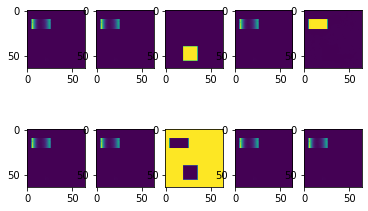

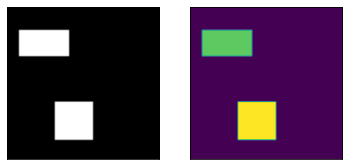

In [7]:
outputs = percept_model(img, gt_seg.unsqueeze(1))
masks = outputs["masks"]
print(outputs["alive"].flatten())
fig = plt.figure("masks")
for i in range(masks.shape[-1]):
    ax = fig.add_subplot(2,5,1+i)
    ax.imshow(masks[0,:,:,i])
""" Down Cast the images into the resolution of (128,128)"""
fig = plt.figure("down sample images")
ax1 = fig.add_subplot(121)
ax1.imshow(img[0].permute(1,2,0)); plt.xticks([]); plt.yticks([])
ax2 = fig.add_subplot(122)
ax2.imshow(gt_seg[0]); plt.xticks([]); plt.yticks([])
plt.show()

shape:[1, 4096, 26] max:1.0 min:1.0132801715745376e-12
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])


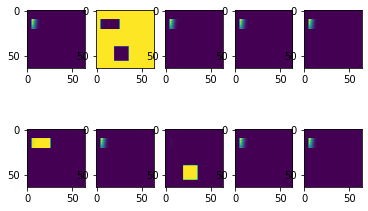

In [8]:
"""Test the graph propagation and the adjacency training in the optimum sense"""
from karanir.thanagor.perception.propagation import GraphPropagation
from karanir.thanagor.perception.competition import Competition
from karanir.utils.tensor import local_to_sparse_global_affinity, logit
from torch_sparse import SparseTensor

propagator = GraphPropagation(num_iters = 72) # graph propagation module
competition = Competition(num_masks = 10, num_competition_rounds= 10) # mask extraction via competition

"""Build a test case to segment simple data like squares and other geometrics"""
H, W = (128,128)
B = 1


"""Start the visual grouping configuration"""
B, C, W, H = img.shape
D = 128
num_long_range = 1


flat_features = 0
flat_targets = gt_seg.clone().reshape([B,W*H]) #[B,N]

v_indices = generate_local_indices([W, H], 5, "constant").long()
v_indices = torch.cat([
    v_indices, torch.randint(H * W, [B, H*W, num_long_range])
], dim = -1)
B, N, K = v_indices.shape
b_indices = torch.arange(B).reshape([1,B,1,1]).repeat(1,1,H*W,K)
u_indices = torch.arange(W * H).reshape([1,W*W,1]).repeat(B,1,K).long()

flat_targets = flat_targets.unsqueeze(-1).repeat(1,1,K)
u_seg = torch.gather(flat_targets, 1, u_indices)
v_seg = torch.gather(flat_targets, 1, v_indices)

"""Calculate the ideal logits"""
valid_mask = 1.0

connectivity = (u_seg == v_seg) * valid_mask
connectivity = logit(connectivity)
connectivity = torch.softmax(connectivity, dim = -1)
connectivity = connectivity / connectivity.max(-1, keepdim = True)[0]
stats_summary(connectivity)

sample_indices = torch.cat([
    b_indices,u_indices.unsqueeze(0), v_indices.unsqueeze(0)
], dim = 0)

h0= torch.FloatTensor(B,N,D).normal_()
adj = local_to_sparse_global_affinity(connectivity.float(), sample_indices,sparse_transpose=True)
prop_map = propagator(h0, adj)[-1].reshape([B,W,H,D])

masks, agents, alive, phenotypes, _ = competition(prop_map)

fig = plt.figure("masks")
for i in range(masks.shape[-1]):
    ax = fig.add_subplot(2,5,1+i)
    ax.imshow(masks[0,:,:,i])
print(alive.reshape(-1))

import functools
import tensorflow as tf
import numpy as np
# Modified from https://github.com/deepmind/multi_object_datasets to
# work in TensorFlow 2

COMPRESSION_TYPE = tf.io.TFRecordOptions.get_compression_type_string('GZIP')
IMAGE_SIZE = [64, 64]
# The maximum number of foreground and background entities in each variant
# of the provided datasets. The values correspond to the number of
# segmentation masks returned per scene.
MAX_NUM_ENTITIES = {
    'train': 7,
    'six_objects': 10,
    'empty_room': 4,
    'identical_color': 10
}
BYTE_FEATURES = ['mask', 'image']


def feature_descriptions(max_num_entities):
  """Create a dictionary describing the dataset features.
  Args:
    max_num_entities: int. The maximum number of foreground and background
      entities in each image. This corresponds to the number of segmentation
      masks returned per scene.
  Returns:
    A dictionary which maps feature names to `tf.Example`-compatible shape and
    data type descriptors.
  """
  return {
      'image': tf.io.FixedLenFeature(IMAGE_SIZE+[3], tf.string),
      'mask': tf.io.FixedLenFeature([max_num_entities]+IMAGE_SIZE+[1], tf.string),
  }


def _decode(example_proto, features):
  # Parse the input `tf.Example` proto using a feature description dictionary.
  single_example = tf.io.parse_single_example(example_proto, features)
  for k in BYTE_FEATURES:
    single_example[k] = tf.squeeze(tf.io.decode_raw(single_example[k], tf.uint8),
                                   axis=-1)
  return single_example


def dataset(tfrecords_path, dataset_variant, read_buffer_size=None,
            map_parallel_calls=None):
  """Read, decompress, and parse the TFRecords file.
  Args:
    tfrecords_path: str. Path to the dataset file.
    dataset_variant: str. One of ['train', 'six_objects', 'empty_room',
      'identical_color']. This is used to identify the maximum number of
      entities in each scene. If an incorrect identifier is passed in, the
      TFRecords file will not be read correctly.
    read_buffer_size: int. Number of bytes in the read buffer. See documentation
      for `tf.data.TFRecordDataset.__init__`.
    map_parallel_calls: int. Number of elements decoded asynchronously in
      parallel. See documentation for `tf.data.Dataset.map`.
  Returns:
    An unbatched `tf.data.TFRecordDataset`.
  """
  if dataset_variant not in MAX_NUM_ENTITIES:
    raise ValueError('Invalid `dataset_variant` provided. The supported values'
                     ' are: {}'.format(list(MAX_NUM_ENTITIES.keys())))
  max_num_entities = MAX_NUM_ENTITIES[dataset_variant]
  raw_dataset = tf.data.TFRecordDataset(
      tfrecords_path, compression_type=COMPRESSION_TYPE,
      buffer_size=read_buffer_size)
  features = feature_descriptions(max_num_entities)
  partial_decode_fn = functools.partial(_decode, features=features)
  return raw_dataset.map(partial_decode_fn,
                         num_parallel_calls=map_parallel_calls)

tf_records_path = '/Users/melkor/Documents/datasets/objects_room_train.tfrecords'
save_path = "/Users/melkor/Documents/datasets/object_room_tf/{}"

train_dataset = dataset(tf_records_path, "train")
import matplotlib.pyplot as plt
import tqdm
itr = 0
for sample in tqdm.tqdm(train_dataset):
    sample;
    img = sample["image"]
    mask = sample["mask"]

    img = np.array(img)
    mask = np.array(mask)
    plt.imsave(save_path.format(str(itr)+".png"),img)
    np.save(save_path.format(itr), mask)
    itr += 1